In [1]:
from typing import List, TypedDict, Literal
from pydantic import BaseModel, Field
import time

import warnings
warnings.filterwarnings("ignore")

from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate

from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
docs = (
    PyPDFLoader("./data/pdfs/policies.pdf").load()
    + PyPDFLoader("./data/pdfs/profile.pdf").load()
    + PyPDFLoader("./data/pdfs/product_pricing.pdf").load()
)

In [3]:
chunks = RecursiveCharacterTextSplitter(chunk_size=600, chunk_overlap=150).split_documents(docs)
# Different chunk sizes tested using chunkviz.up.railway.app

In [4]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = FAISS.from_documents(chunks, embeddings)
retriever = vector_store.as_retriever(search_kwargs={"k":4}) #top4 docs

In [5]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [6]:
# Graph State
class State(TypedDict):
    question: str
    need_retrieval: bool
    docs: List[Document]
    relevant_docs: List[Document]
    context: str
    answer: str
    #Hallucination Evaluation fields
    is_supported: Literal["fully_supported", "partially_supported", "not_supported"]
    evidence: List[str]
    retries: int
    is_use: Literal["useful", "not_useful"]
    use_reason: str
    # Query rewrite
    retrieval_query: str
    rewrite_tries: int


In [7]:
class RetrieveDecision(BaseModel):
    should_retrieve: bool = Field(..., description="True if external documents are needed to answer the question, False otherwise.")

decide_retrieval_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an assistant that decides whether retrieval is needed.\n"
     "Return JSON that matches this schema:\n"
     "{{'should_retrieve': bool}}\n\n"
     "Guidelines:\n"
     "- should_retrieve=True if answering requires specific facts, citations or info likely not in the model.\n"
     "- should_retrieve=False for general explanations, definitions, or reasoning that doesn't need sources.\n"
     "- If unsure, lean towards should_retrieve=True to ensure accuracy.\n"),
    ("human", "Question: {question}"),
]
)

should_retrieve_llm = llm.with_structured_output(RetrieveDecision)

def decide_retrieval(state: State):
    decision: RetrieveDecision = should_retrieve_llm.invoke(decide_retrieval_prompt.format_messages(question=state['question']))
    return {"need_retrieval": decision.should_retrieve}

def route_after_decide(state: State)-> Literal["generate_direct", "retrieve"]:
    if state['need_retrieval']:
        return "retrieve"
    else:
        return "generate_direct"

In [8]:
direct_generation_prompt = ChatPromptTemplate.from_messages([
    ("system", 
     "Answer the question using only your general knowledge.\n"
     "Do NOT assume access to external documents.\n"
     "If you are unsure or the answer requires specific sources, say:\n"
     "'I don't know based on my current knowledge.'"),
    ("human", "{question}"),
])

def generate_direct(state:State):
    out = llm.invoke(direct_generation_prompt.format_messages(question=state['question']))
    return {"answer": out.content}

In [9]:
def retrieve(state: State):
    q = state.get("retrieval_query") or state["question"]
    return {"docs": retriever.invoke(q)}

In [10]:
# Can be simply replaced by a web search result and the answer will return to is_relevant again 
def no_answer_found(state: State):
    return {"answer": "No relevant document found.", "context": ""}

In [11]:
class RelevanceDecision(BaseModel):
    is_relevant: bool = Field(..., description="True if the document helps answer the question, False otherwise.")

is_relevant_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are judging document relevance.\n"
        "Return JSON that matches this schema:\n"
        "{{'is_relevant': boolean}}\n\n"
        "A document is relevant if it contains information that directly helps answer the question."
    ),
    (
        "human",
        "Question:\n{question}\n\nDocument:\n{document}"
    )
    ])
relevance_llm = llm.with_structured_output(RelevanceDecision)

def is_relevant(state: State):
    relevant_docs: List[Document] = []
    for doc in state['docs']:
        decision: RelevanceDecision = relevance_llm.invoke(
            is_relevant_prompt.format_messages(question=state['question'], document=doc.page_content)
        )

        if decision.is_relevant:
            relevant_docs.append(doc)
    return {"relevant_docs": relevant_docs}

def route_after_relevance(state: State) -> Literal["generate_from_context", "no_answer_found"]:
    if state.get("relevant_docs") and len(state["relevant_docs"]) > 0:
        return "generate_from_context"
    return "no_answer_found"

In [12]:
rag_generation_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are a startup RAG assistant.\n"
        "Answer the user's question using only the provided context.\n"
        "If the context does not contain enough information, say:\n"
        "'No relevant document found.'\n"
        "Do not use outside knowledge - rely solely on the context.\n"
    ),
    (
        "human",
        "Question:\n{question}\n\n"
        "Context:\n{context}\n"
    )
])

def generate_from_context(state: State):
    context = "\n\n---\n\n".join([doc.page_content for doc in state.get("relevant_docs", [])]).strip()
    
    if not context:
        return {"answer": "No relevant document found.", "context": ""}
    
    out = llm.invoke(rag_generation_prompt.format_messages(question=state['question'], context=context))
    return {"answer": out.content, "context": context}

In [13]:
class IsSupportedDecision(BaseModel):
    issupported: Literal["fully_supported", "partially_supported", "not_supported"]
    evidence: List[str] = Field(default_factory=list)

issup_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are verifying whether the ANSWER is supported by the CONTEXT.\n"
            "Return JSON with keys: issupported, evidence.\n"
            "issupported must be one of: fully_supported, partially_supported, not_supported.\n\n"
            "How to decide issupported:\n"
            "- fully_supported:\n"
            "  Every meaningful claim is explicitly supported by CONTEXT, and the ANSWER does NOT introduce\n"
            "  any qualitative/interpretive words that are not present in CONTEXT.\n"
            "  (Examples of disallowed words unless present in CONTEXT: culture, generous, robust, designed to,\n"
            "  supports professional development, best-in-class, employee-first, etc.)\n\n"
            "- partially_supported:\n"
            "  The core facts are supported, BUT the ANSWER includes ANY abstraction, interpretation, or qualitative\n"
            "  phrasing not explicitly stated in CONTEXT (e.g., calling policies 'culture', saying leave is 'generous',\n"
            "  or inferring outcomes like 'supports professional development').\n\n"
            "- not_supported:\n"
            "  The key claims are not supported by CONTEXT.\n\n"
            "Rules:\n"
            "- Be strict: if you see ANY unsupported qualitative/interpretive phrasing, choose partially_supported.\n"
            "- If the answer is mostly unrelated to the question or unsupported, choose not_supported.\n"
            "- Evidence: include up to 3 short direct quotes from CONTEXT that support the supported parts.\n"
            "- Do not use outside knowledge."
        ),
        (
            "human",
            "Question:\n{question}\n\n"
            "Answer:\n{answer}\n\n"
            "Context:\n{context}\n"
        ),
    ]
)


issup_llm = llm.with_structured_output(IsSupportedDecision)

def is_supported(state: State):
    decision: IsSupportedDecision = issup_llm.invoke(
        issup_prompt.format_messages(
            question=state["question"],
            answer=state.get("answer", ""),
            context=state.get("context", ""),
        )
    )
    return {"is_supported": decision.issupported, "evidence": decision.evidence}

MAX_RETRIES = 5

def route_after_issupported(state: State) -> Literal["accept_answer", "revise_answer"]:
    # accept if fully supported
    if state.get("is_supported") == "fully_supported":
        return "accept_answer"

    # stop if we've already tried enough
    if state.get("retries", 0) >= MAX_RETRIES:
        return "accept_answer"   # or return a "give_up" node

    # otherwise revise again
    return "revise_answer"

In [14]:
def accept_answer(state: State):
    return {}

In [15]:
revise_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a STRICT reviser.\n\n"
            "You must output based on the following format:\n\n"
            "FORMAT (quote-only answer):\n"
            "- <direct quote from the CONTEXT>\n"
            "- <direct quote from the CONTEXT>\n\n"
            "Rules:\n"
            "- Use ONLY the CONTEXT.\n"
            "- Do NOT add any new words besides bullet dashes and the quotes themselves.\n"
            "- Do NOT explain anything.\n"
            "- Do NOT say 'context', 'not mentioned', 'does not mention', 'not provided', etc.\n"
        ),
        (
            "human",
            "Question:\n{question}\n\n"
            "Current Answer:\n{answer}\n\n"
            "CONTEXT:\n{context}"
        ),
    ]
)



def revise_answer(state: State):
    out = llm.invoke(
        revise_prompt.format_messages(
            question=state["question"],
            answer=state.get("answer", ""),
            context=state.get("context", ""),
        )
    )
    return {
        "answer": out.content,
        "retries": state.get("retries", 0) + 1,  # ✅ increment
    }

In [16]:
class IsUSEDecision(BaseModel):
    isuse: Literal["useful", "not_useful"]
    reason: str = Field(..., description="Short reason in 1 line.")

isuse_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are judging USEFULNESS of the ANSWER for the QUESTION.\n\n"
            "Goal:\n"
            "- Decide if the answer actually addresses what the user asked.\n\n"
            "Return JSON with keys: isuse, reason.\n"
            "isuse must be one of: useful, not_useful.\n\n"
            "Rules:\n"
            "- useful: The answer directly answers the SPECIFIC question asked using the EXACT concept/topic requested.\n"
            "- not_useful: The answer is generic, off-topic, uses related but DIFFERENT concepts (e.g., 'values' when asked for 'culture'), or only provides background without answering.\n"
            "- Be strict: if the question asks for X but answer provides Y (even if related), mark as not_useful.\n"
            "- Do NOT use outside knowledge.\n"
            "- Do NOT re-check grounding (IsSUP already did that). Only check: 'Did we answer the question?'\n"
            "- Keep reason to 1 short line."
        ),
        (
            "human",
            "Question:\n{question}\n\nAnswer:\n{answer}"
        ),
    ]
)

isuse_llm = llm.with_structured_output(IsUSEDecision)

def is_use(state: State):
    decision: IsUSEDecision = isuse_llm.invoke(
        isuse_prompt.format_messages(
            question=state["question"],
            answer=state.get("answer", ""),
        )
    )
    return {"is_use": decision.isuse, "use_reason": decision.reason}

MAX_REWRITE_TRIES = 3

def route_after_isuse(state: State) -> Literal["END", "rewrite_question", "no_answer_found"]:
    if state.get("isuse") == "useful":
        return "END"

    if state.get("rewrite_tries", 0) >= MAX_REWRITE_TRIES:
        return "no_answer_found"

    return "rewrite_question"

In [17]:
class RewriteDecision(BaseModel):
    retrieval_query: str = Field(
        ...,
        description="Rewritten query optimized for vector retrieval against internal company PDFs."
    )

rewrite_for_retrieval_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Rewrite the user's QUESTION into a query optimized for vector retrieval over INTERNAL company PDFs.\n\n"
            "Rules:\n"
            "- Keep it short (6–16 words).\n"
            "- Preserve key entities (e.g., NexaAI, plan names).\n"
            "- Add 2–5 high-signal keywords that likely appear in policy/pricing docs.\n"
            "- Remove filler words.\n"
            "- Do NOT answer the question.\n"
            "- Output JSON with key: retrieval_query\n\n"
            "Examples:\n"
            "Q: 'Do NexaAI plans include a free trial?'\n"
            "-> {{'retrieval_query': 'NexaAI free trial duration trial period plans'}}\n\n"
            "Q: 'What is NexaAI refund policy?'\n"
            "-> {{'retrieval_query': 'NexaAI refund policy cancellation refund timeline charges'}}"
        ),
        (
            "human",
            "QUESTION:\n{question}\n\n"
            "Previous retrieval query:\n{retrieval_query}\n\n"
            "Answer (if any):\n{answer}"
        ),
    ]
)

rewrite_llm = llm.with_structured_output(RewriteDecision)

def rewrite_question(state: State):
    decision: RewriteDecision = rewrite_llm.invoke(
        rewrite_for_retrieval_prompt.format_messages(
            question=state["question"],
            retrieval_query=state.get("retrieval_query", ""),
            answer=state.get("answer", ""),
        )
    )

    return {
        "retrieval_query": decision.retrieval_query,
        "rewrite_tries": state.get("rewrite_tries", 0) + 1,
        "docs": [],
        "relevant_docs": [],
        "context": "",
    }

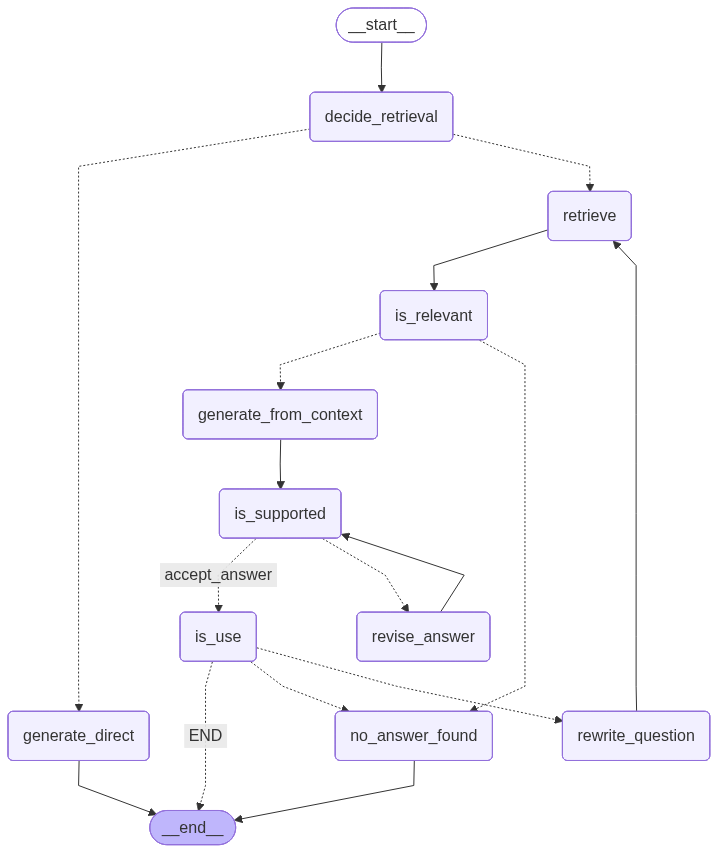

In [18]:
g = StateGraph(State)

g.add_node("decide_retrieval", decide_retrieval)
g.add_node("generate_direct", generate_direct)
g.add_node("retrieve", retrieve)

g.add_node("is_relevant", is_relevant)
g.add_node("generate_from_context", generate_from_context)
g.add_node("no_answer_found", no_answer_found)

g.add_node("is_supported", is_supported)
g.add_node("revise_answer", revise_answer)
g.add_node("is_use", is_use)
g.add_node("rewrite_question", rewrite_question)

g.add_edge(START, "decide_retrieval")
g.add_conditional_edges(
    "decide_retrieval",
    route_after_decide,
    {
        "generate_direct": "generate_direct",
        "retrieve": "retrieve"
    }
)
g.add_edge("generate_direct", END)
g.add_edge("retrieve", "is_relevant")
g.add_conditional_edges(
    "is_relevant",
    route_after_relevance,
    {
        "generate_from_context": "generate_from_context",
        "no_answer_found": "no_answer_found"
    }
)
g.add_edge("no_answer_found", END)

g.add_edge("generate_from_context", "is_supported")
g.add_conditional_edges(
    "is_supported",
    route_after_issupported,
    {"accept_answer": "is_use", "revise_answer": "revise_answer"
    },
)
g.add_edge("revise_answer", "is_supported")

g.add_conditional_edges(
    "is_use",
    route_after_isuse,
    {"END": END, "rewrite_question": "rewrite_question", "no_answer_found": "no_answer_found",},
)

g.add_edge("rewrite_question", "retrieve")


app = g.compile()
app

In [19]:
initial_state = {
    "question": "Describe NexaAI’s company culture.",
    "retrieval_query": "What is the refund policy of NexaAI",  
    "rewrite_tries": 0,                                        
    "docs": [],
    "relevant_docs": [],
    "context": "",
    "answer": "",
    "issup": "",
    "evidence": [],
    "retries": 0,
    "isuse": "not_useful",
    "use_reason": "",
}


result = app.invoke(
    initial_state,
    config={"recursion_limit": 80},  # allow revise → verify loops
)

In [20]:
print("\n===== RAG EXECUTION RESULT =====\n")

print("Question:", initial_state.get("question"))
print("Need Retrieval:", result.get("need_retrieval"))

# If you added these counters/fields in your State:
print("Rewrite tries (retrieval):", result.get("rewrite_tries", 0))
print("Support revise tries:", result.get("retries", 0))

print("\nRetrieval:")
print("  Total retrieved docs:", len(result.get("docs", []) or []))
print("  Relevant docs:", len(result.get("relevant_docs", []) or []))

# Optional: show sources/pages for relevant docs
relevant_docs = result.get("relevant_docs", []) or []
if relevant_docs:
    print("\nRelevant docs (source/page):")
    for i, d in enumerate(relevant_docs, 1):
        src = (d.metadata or {}).get("source", "unknown")
        page = (d.metadata or {}).get("page", None)
        title = (d.metadata or {}).get("title", "")
        extra = f", title={title}" if title else ""
        if page is not None:
            print(f"  {i}. source={src}, page={page}{extra}")
        else:
            print(f"  {i}. source={src}{extra}")

print("\nVerification (IsSUP):")
print("  issup:", result.get("issup"))
evidence = result.get("evidence", []) or []
if evidence:
    print("  evidence:")
    for e in evidence:
        print("   -", e)
else:
    print("  evidence: (none)")

print("\nUsefulness (IsUSE):")
print("  isuse:", result.get("isuse"))
print("  reason:", result.get("use_reason", ""))

print("\nFinal Answer:")
print(result.get("answer"))


===== RAG EXECUTION RESULT =====

Question: Describe NexaAI’s company culture.
Need Retrieval: True
Rewrite tries (retrieval): 0
Support revise tries: 0

Retrieval:
  Total retrieved docs: 4
  Relevant docs: 0

Verification (IsSUP):
  issup: None
  evidence: (none)

Usefulness (IsUSE):
  isuse: None
  reason: 

Final Answer:
No relevant document found.


# Culture != Values - Hallucination Detection (Possible because of is_supported step)
"question": "Describe NovamindAI’s company culture"
evidence: ['NovaMind AI operates under five core values: Transparency (in model behavior and business)', 'All NovaMind AI employees, contractors, and partners are expected to uphold the highest standards of integrity, professionalism, and ethical behavior.']
answer: - "NovaMind AI operates under five core values: Transparency (in model behavior and business)"
- "All NovaMind AI employees, contractors, and partners are expected to uphold the highest standards of integrity, professionalism, and ethical behavior."

In [21]:
result['docs']

[Document(id='db0e2b65-b738-4b48-82e6-3d47d1212cdb', metadata={'producer': 'PyPDF', 'creator': 'Microsoft Word', 'creationdate': '2026-02-20T21:55:26+00:00', 'author': 'Sai Akhil Rayapudi', 'moddate': '2026-02-20T21:55:26+00:00', 'source': './policies.pdf', 'total_pages': 2, 'page': 0, 'page_label': '1'}, page_content='NovaMind AI — Company Policies \nVersion 3.1 | Effective Date: January 1, 2025 | Reviewed by: People & Legal \n1. Code of Conduct \nAll NovaMind AI employees, contractors, and partners are expected to uphold the highest \nstandards of integrity, professionalism, and ethical behavior. Any action that compromises the \ntrust of customers, colleagues, or stakeholders is grounds for immediate review and potential \ntermination. \n• Treat all individuals with respect regardless of role, background, or identity. \n• Report conflicts of interest promptly to your direct manager and the Legal team.'),
 Document(id='5c0e69ee-1042-44a7-b7f0-074540ba01b9', metadata={'producer': 'PyP

In [22]:
result['relevant_docs']

[]

In [23]:
# How many employees does NovamindAI have?
# Describe NovamindAI’s company culture.
# Do NovamindAI plans include a free trial? If yes, how many days?